## Analyzing and Visualizing Census Rent Data

See the data and map in action at .

I loaded and geocoded the 2014 ACS 1-year median contract rent data in this notebook. Now, it's time to merge this data with the 2010 ACS rents and the 2010/2014 population data. The next steps are to analyze it, visualize it, map it, and then save it to GeoJSON so we can create an interactive web map using Leaflet.



In [66]:
# Install GeoPandas if not already installed
!pip install geopandas

# Import necessary libraries for data manipulation and analysis
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

# Import statistical models library
import statsmodels.api as sm  # For statistical modeling and hypothesis testing

# Import Matplotlib for plotting and visualization
import matplotlib.font_manager as fm  # For managing fonts
import matplotlib.pyplot as plt  # For creating plots and visualizations
import matplotlib.cm as cm  # For managing colormap options in plots

# Import Basemap for geographical plotting
from mpl_toolkits.basemap import Basemap  # For creating maps and plotting geographic data

# Import GeoPandas for handling geospatial data
from geopandas import GeoDataFrame  # For creating and working with geospatial dataframes

# Import Shapely for geometric operations
from shapely.geometry import Point  # For creating point geometries

# Enable inline plotting for Jupyter notebooks
%matplotlib inline  # Ensures that plots are displayed inline within Jupyter notebooks


UsageError: unrecognized arguments: # Ensures that plots are displayed inline within Jupyter notebooks


In [67]:
# Define the font family to use for plots
font_family = 'Myriad Pro'

# Define the font properties for the plot title
# family: the font family
# style: the font style (e.g., 'normal', 'italic')
# size: the font size
# weight: the weight of the font (e.g., 'normal', 'bold')
# stretch: the stretch of the font (e.g., 'normal', 'condensed')
title_font = fm.FontProperties(family=font_family, style='normal', size=18, weight='normal', stretch='normal')

# Define the font properties for the plot labels
label_font = fm.FontProperties(family=font_family, style='normal', size=16, weight='normal', stretch='normal')

# Define the font properties for the plot ticks
ticks_font = fm.FontProperties(family=font_family, style='normal', size=14, weight='normal', stretch='normal')


In [68]:
# Load the 2014 geolocated rent data from a CSV file
# 'data/rent_latlong.csv' should be the path to your CSV file containing the rent data
rent14 = pd.read_csv('data/rent_latlong.csv')

# Rename the column 'geo_id2' to 'geo_id_14' for clarity and consistency
rent14 = rent14.rename(columns={'geo_id2': 'geo_id_14'})

# Select relevant columns for analysis: 'geo_id_14', 'msa_name', 'city_state',
# 'median_contract_rent', 'latitude', and 'longitude'
rent14 = rent14[['geo_id_14', 'msa_name', 'city_state', 'median_contract_rent', 'latitude', 'longitude']]

# Display the first few rows of the dataframe to verify the changes
print(rent14.head())


   geo_id_14                   msa_name      city_state  median_contract_rent  \
0      10140    Aberdeen, WA Micro Area    Aberdeen, WA                   626   
1      10180     Abilene, TX Metro Area     Abilene, TX                   613   
2      10300      Adrian, MI Micro Area      Adrian, MI                   556   
3      10420       Akron, OH Metro Area       Akron, OH                   627   
4      10460  Alamogordo, NM Micro Area  Alamogordo, NM                   700   

    latitude   longitude  
0  46.975371 -123.815722  
1  32.448736  -99.733144  
2  41.897547  -84.037166  
3  41.081445  -81.519005  
4  32.899532 -105.960265  


In [69]:

# Load the 2010 rent data from the specified CSV file into a DataFrame
rent10 = pd.read_csv('data/ACS_10_1YR_B25058_metro_micro/ACS_10_1YR_B25058.csv')

# Rename columns to more readable names
rent10 = rent10.rename(columns={
    'GEO.id': 'geo_id',               # Original geographic ID
    'GEO.id2': 'geo_id_10',           # Secondary geographic ID (likely a more specific identifier)
    'GEO.display-label': 'msa_name',  # Metropolitan Statistical Area (MSA) name
    'HD01_VD01': 'median_rent_10',    # Median rent for 2010
    'HD02_VD01': 'margin_error'       # Margin of error for the median rent estimate
})

# Select only the columns 'geo_id_10' and 'median_rent_10' for further analysis
rent10 = rent10[['geo_id_10', 'median_rent_10']]

# Display the first few rows of the DataFrame to verify the changes
print(rent10.head())


   geo_id_10  median_rent_10
0      10140             562
1      10180             554
2      10300             537
3      10420             579
4      10500             477


### Merging 2010 and 2014 ACS Rent Data

To merge the 2010 and 2014 ACS rent data effectively, follow these steps:

1. **Load the Data**: Read the 2010 and 2014 ACS rent data into pandas DataFrames.
2. **Rename Columns**: Ensure both DataFrames have consistent column names to facilitate merging.
3. **Create a Mapping Dictionary**: Map 2014 codes to 2010 codes for areas that have changed. 
   - Some areas have changed names or codes between 2010 and 2014, and for these, you will need to create a mapping dictionary.
4. **Apply the Mapping**: Use the mapping dictionary to update the 2014 codes to their corresponding 2010 codes.
5. **Select Relevant Columns**: Choose the necessary columns from both DataFrames for comparison.
6. **Merge the DataFrames**: Combine the data on the 2010 geo_id using an inner join to retain only areas with data in both years.
7. **Handle Unmatched Data**: Ignore areas that are new in 2014 or were dropped since 2010, as they cannot be compared without data from both years.

Following these steps ensures that your merged dataset is accurate and includes only comparable rent data from both years, allowing for effective analysis.

In [70]:
# Import pandas library
import pandas as pd

# Define a dictionary to map 2014 codes to 2010 codes for areas that changed
codes_14_10 = {  # Format: 2014_code:2010_code
    14010: 14060,  # Bloomington, IL
    15680: 30500,  # Lexington Park, MD
    16060: 32060,  # Marion, IL
    17200: 30100,  # Lebanon, NH
    25840: 37820,  # Pendleton
    26090: 26100,  # Holland
    29200: 29140,  # Lafayette
    38240: 43860,  # Pinehurst
    41400: 20620,  # Salem, OH
    48260: 44600,  # Weirton
    49220: 32270,  # Wisconsin Rapids
    31080: 31100,  # Los Angeles
    42200: 42060,  # Santa Barbara
    46520: 26180,  # Honolulu
    48260: 44600   # Steubenville
}

# Create a new column 'geo_id_10' in the 2014 DataFrame to hold the corresponding 2010 code
# The lambda function maps each 2014 geo_id to its corresponding 2010 geo_id using the 'codes_14_10' dictionary
# If a 2014 geo_id is not in the dictionary (i.e., the area is new or dropped), it retains the original 2014 geo_id
rent14['geo_id_10'] = rent14['geo_id_14'].map(lambda x: codes_14_10[x] if x in codes_14_10.keys() else x)


In [71]:
# Import pandas library
import pandas as pd

# Merge the 2014 and 2010 rent datasets on the 'geo_id_10' column
# 'rent14' contains the 2014 rent data with the 'geo_id_10' column mapped to 2010 codes
# 'rent10' contains the 2010 rent data
rent = pd.merge(rent14, rent10, on='geo_id_10')

# Display the first few rows of the merged DataFrame to verify the merge
rent.head()


,geo_id_14,msa_name,city_state,median_contract_rent,latitude,longitude,geo_id_10,median_rent_10
0,10140,"Aberdeen, WA Micro Area","Aberdeen, WA",626,46.975371,-123.815722,10140,562
1,10180,"Abilene, TX Metro Area","Abilene, TX",613,32.448736,-99.733144,10180,554
2,10300,"Adrian, MI Micro Area","Adrian, MI",556,41.897547,-84.037166,10300,537
3,10420,"Akron, OH Metro Area","Akron, OH",627,41.081445,-81.519005,10420,579
4,10500,"Albany, GA Metro Area","Albany, GA",480,31.578507,-84.155741,10500,477


In [72]:
# Calculate the percentage change in median rent from 2010 to 2014
# Create a new column 'rent_change_pct' to store the percentage change
rent['rent_change_pct'] = (rent['median_contract_rent'] / rent['median_rent_10'] - 1) * 100

# Sort the DataFrame by the 'rent_change_pct' column to see the changes
# Display the first few rows of the sorted DataFrame, showing the 'msa_name' and 'rent_change_pct'
rent.sort_values(by='rent_change_pct')[['msa_name', 'rent_change_pct']].head()


,msa_name,rent_change_pct
414,"Seneca, SC Micro Area",-14.417745
413,"Sebring, FL Metro Area",-11.992945
69,"Carson City, NV Metro Area",-9.015257
464,"Valdosta, GA Metro Area",-7.992895
442,"Talladega-Sylacauga, AL Micro Area",-7.049608


### Loading the Population Data

Now, let's load the population data. This file contains:
- 2014 population estimates
- 2010 population values from the census

By importing this data, you can analyze the population changes over these years.

In [73]:
# Import pandas library
import pandas as pd

# Load the population data from the specified CSV file into a DataFrame
# 'encoding=utf-8' ensures that the data is read correctly, especially if it contains special characters
pops = pd.read_csv('data/PEP_2014_PEPANNRES/PEP_2014_PEPANNRES.csv', encoding='utf-8')

# Rename columns for better readability and consistency
# 'GEO.id2' is renamed to 'geo_id_14' to match the 2014 geographic ID
# 'rescen42010' is renamed to 'pop_10' representing the population in 2010
# 'respop72014' is renamed to 'pop_est_14' representing the estimated population in 2014
pops = pops.rename(columns={
    'GEO.id2': 'geo_id_14',  # 2014 geographic ID
    'rescen42010': 'pop_10',  # Population in 2010
    'respop72014': 'pop_est_14'  # Estimated population in 2014
})

# Select only the necessary columns for analysis
# 'geo_id_14' for the 2014 geographic ID
# 'pop_10' for the 2010 population
# 'pop_est_14' for the 2014 estimated population
pops = pops[['geo_id_14', 'pop_10', 'pop_est_14']]

# Display the first few rows of the DataFrame to verify the changes
# This helps ensure the data has been loaded and processed correctly
pops.head()


,geo_id_14,pop_10,pop_est_14
0,10100,40602,42391
1,10140,72797,70818
2,10180,165252,168592
3,10220,37492,38005
4,10300,99892,99047


In [74]:
# Merge the 'rent' DataFrame with the 'pops' DataFrame on the 'geo_id_14' column
# This combines the datasets where the 'geo_id_14' in 'rent' matches 'geo_id_14' in 'pops'
df = pd.merge(rent, pops, on='geo_id_14')

# Display the first few rows of the merged DataFrame
# This is useful for verifying the merged result and checking if the data aligns correctly
df.head()


,geo_id_14,msa_name,city_state,median_contract_rent,latitude,longitude,geo_id_10,median_rent_10,rent_change_pct,pop_10,pop_est_14
0,10140,"Aberdeen, WA Micro Area","Aberdeen, WA",626,46.975371,-123.815722,10140,562,11.387900,72797,70818
1,10180,"Abilene, TX Metro Area","Abilene, TX",613,32.448736,-99.733144,10180,554,10.649819,165252,168592
2,10300,"Adrian, MI Micro Area","Adrian, MI",556,41.897547,-84.037166,10300,537,3.538175,99892,99047
3,10420,"Akron, OH Metro Area","Akron, OH",627,41.081445,-81.519005,10420,579,8.290155,703200,703825
4,10500,"Albany, GA Metro Area","Albany, GA",480,31.578507,-84.155741,10500,477,0.628931,157308,154925


In [75]:
# Calculate the percentage change in population from 2010 to 2014
# Create a new column 'pop_change_pct' to store the percentage change
df['pop_change_pct'] = (df['pop_est_14'] / df['pop_10'] - 1) * 100

# Sort the DataFrame by the 'pop_change_pct' column to see the changes
# Display the first few rows of the sorted DataFrame, showing the 'msa_name' and 'pop_change_pct'
df.sort_values(by='pop_change_pct')[['msa_name', 'pop_change_pct']].head()


,msa_name,pop_change_pct
348,"Pine Bluff, AR Metro Area",-5.527738
142,"Farmington, NM Metro Area",-4.812986
377,"Roanoke Rapids, NC Micro Area",-4.371663
214,"Johnstown, PA Metro Area",-4.139088
277,"Martinsville, VA Micro Area",-3.207203


### Explore relationships in the data with some scatterplots

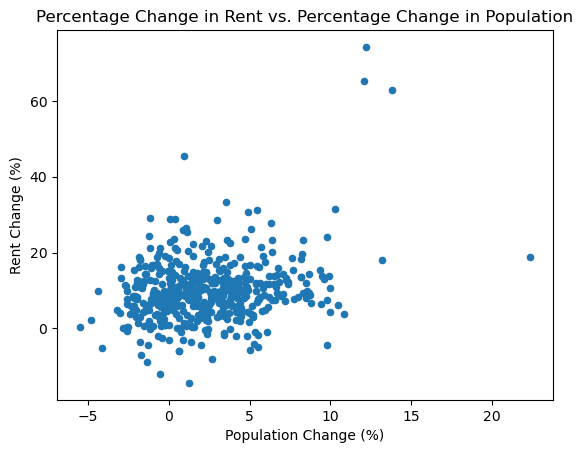

In [76]:
# Create a scatter plot to visualize the relationship between population change and rent change
# 'pop_change_pct' is the x-axis and 'rent_change_pct' is the y-axis
df.plot(kind='scatter', x='pop_change_pct', y='rent_change_pct')

# Add labels and a title to the plot for better understanding
plt.xlabel('Population Change (%)')
plt.ylabel('Rent Change (%)')
plt.title('Percentage Change in Rent vs. Percentage Change in Population')

# Display the plot
plt.show()


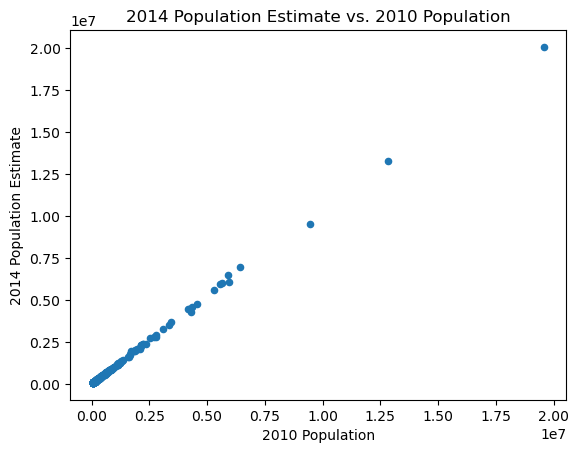

In [78]:
# Create a scatter plot to visualize the relationship between 2010 population and 2014 population estimates
# 'pop_10' is the x-axis and 'pop_est_14' is the y-axis
df.plot(kind='scatter', x='pop_10', y='pop_est_14')

# Add labels and a title to the plot for better understanding
plt.xlabel('2010 Population')
plt.ylabel('2014 Population Estimate')
plt.title('2014 Population Estimate vs. 2010 Population')

# Display the plot
plt.show()


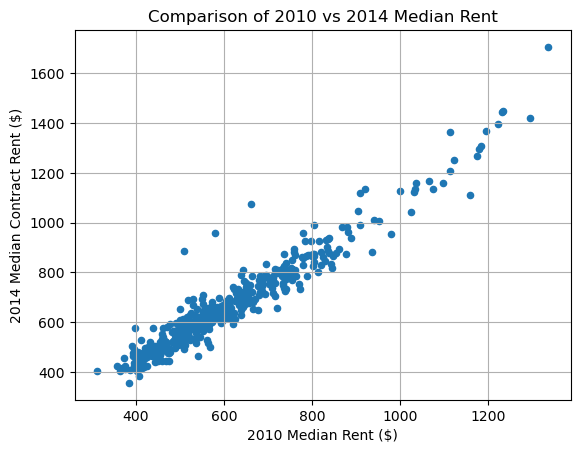

In [79]:
# Create a scatter plot
df.plot(kind='scatter', x='median_rent_10', y='median_contract_rent')

# Customize plot with labels and title for better understanding
plt.xlabel('2010 Median Rent ($)')  # Label for x-axis
plt.ylabel('2014 Median Contract Rent ($)')  # Label for y-axis
plt.title('Comparison of 2010 vs 2014 Median Rent')  # Title of the plot
plt.grid(True)  # Display grid lines for easier visualization
plt.show()  # Display the plot


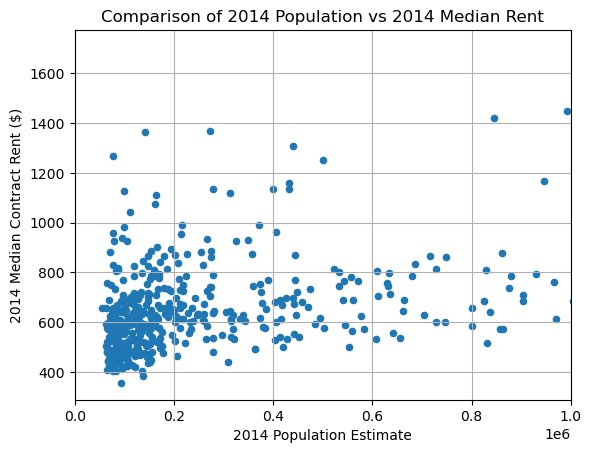

In [80]:
# Create a scatter plot
df.plot(kind='scatter', x='pop_est_14', y='median_contract_rent', xlim=[0, 1000000])

# Customize plot with labels and title for better understanding
plt.xlabel('2014 Population Estimate')  # Label for x-axis
plt.ylabel('2014 Median Contract Rent ($)')  # Label for y-axis
plt.title('Comparison of 2014 Population vs 2014 Median Rent')  # Title of the plot
plt.grid(True)  # Display grid lines for easier visualization
plt.show()  # Display the plot


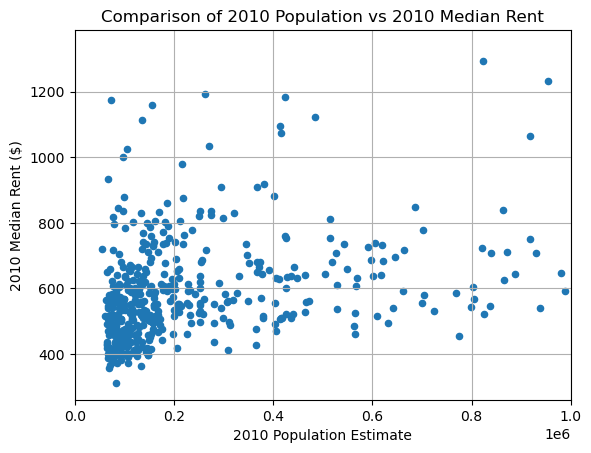

In [81]:
# Create a scatter plot
df.plot(kind='scatter', x='pop_10', y='median_rent_10', xlim=[0, 1000000])

# Customize plot with labels and title for better understanding
plt.xlabel('2010 Population Estimate')  # Label for x-axis
plt.ylabel('2010 Median Rent ($)')  # Label for y-axis
plt.title('Comparison of 2010 Population vs 2010 Median Rent')  # Title of the plot
plt.grid(True)  # Display grid lines for easier visualization
plt.show()  # Display the plot


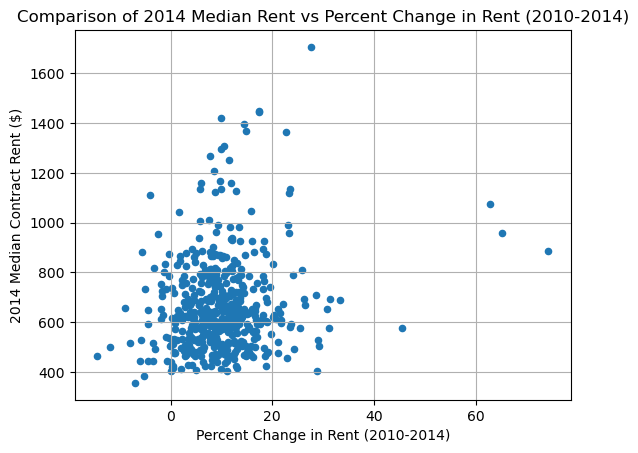

In [82]:
# Create a scatter plot
df.plot(kind='scatter', x='rent_change_pct', y='median_contract_rent')

# Customize plot with labels and title for better understanding
plt.xlabel('Percent Change in Rent (2010-2014)')  # Label for x-axis
plt.ylabel('2014 Median Contract Rent ($)')  # Label for y-axis
plt.title('Comparison of 2014 Median Rent vs Percent Change in Rent (2010-2014)')  # Title of the plot
plt.grid(True)  # Display grid lines for easier visualization
plt.show()  # Display the plot


C:\Users\men_l\AppData\Local\Temp\ipykernel_15816\1363717500.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_est = X_line * results.params[1] + results.params[0]  # Calculate estimated y values using regression parameters
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad Pro' not found.
findfont: Font family 'Myriad P

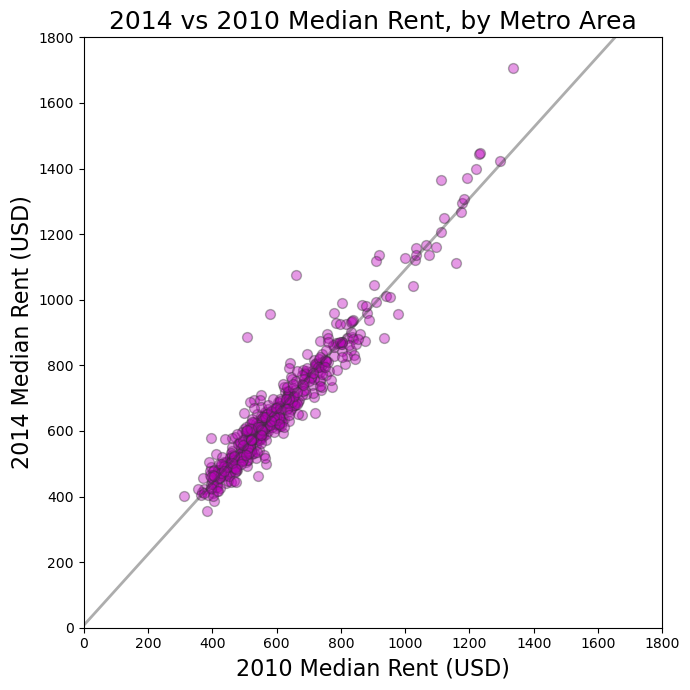

In [84]:
# Plot 2014 median rent vs 2010 median rent
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)  # Set the size of the figure
axis_min = 0  # Minimum value for the axes
axis_max = 1800  # Maximum value for the axes
    
# Regress 2014 rent on 2010 rent
X = df['median_rent_10']  # Independent variable (2010 median rent)
Y = df['median_contract_rent']  # Dependent variable (2014 median rent)
results = sm.OLS(Y, sm.add_constant(X)).fit()  # Perform ordinary least squares (OLS) regression

# Calculate estimated y values for the regression line
X_line = X.copy()  # Copy the independent variable data
X_line.loc[axis_min] = axis_min  # Add minimum value to the data
X_line.loc[axis_max] = axis_max  # Add maximum value to the data
Y_est = X_line * results.params[1] + results.params[0]  # Calculate estimated y values using regression parameters

# Draw points, regression line, and line of 1:1 linear relationship
# ax.plot([axis_min, axis_max], [axis_min, axis_max], 'k-', color='k', alpha=0.3, linewidth=2)  # Line of 1:1 relationship (commented out)
ax.plot(X_line, Y_est, c='#333333', alpha=0.4, linewidth=2)  # Plot the regression line
ax.scatter(X, Y, c='m', edgecolor='#333333', alpha=0.4, s=50)  # Scatter plot of the data points

ax.set_xlim([axis_min, axis_max])  # Set x-axis limits
ax.set_ylim([axis_min, axis_max])  # Set y-axis limits

# Customize plot with labels and title
ax.set_title('2014 vs 2010 Median Rent, by Metro Area', fontproperties=title_font)  # Title of the plot
ax.set_xlabel('2010 Median Rent (USD)', fontproperties=label_font)  # Label for x-axis
ax.set_ylabel('2014 Median Rent (USD)', fontproperties=label_font)  # Label for y-axis

fig.tight_layout()  # Adjust layout to fit elements properly
fig.savefig('images/scatter-rent-change-2010-2014.png', dpi=300)  # Save the plot as an image
plt.show()  # Display the plot
